# Radar Mosiac Plotting

This notebook is an example of downloading, gridding, and plotting radar mosiacs

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import requests

from datetime import datetime, timedelta
from netCDF4 import Dataset

import glob
import os

import pyart

import pandas as pd

import numpy as np

import zipfile

import shutil

import mmmpy


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/research/modules/mpich/miniconda3/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/research/modules/mpich/miniconda3/lib/python3.9/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==52.0.0.post20210125 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


In [7]:
#set date and location bounds
#set time to plot (no leading zeros)
year  = 2021
month = 12
day   = 11
hour  = 0
minute = 0
    
lat_min = 40
lat_max = 50
lon_min = -105
lon_max = -85

dt = datetime(year,month,day,hour,minute)
url = 'https://mrms.agron.iastate.edu/' + dt.strftime('%Y/%m/%d/%Y%m%d%H') + '.zip'
print(dt.hour)

0


In [8]:
#remove any old data
try:
    shutil.rmtree('./mrms_data')
except:
    pass

os.mkdir('./mrms_data')

dt = datetime(year,month,day,hour,minute)

#download file and extract
outfile =  './mrms_data/' + dt.strftime('%Y%m%d%H') + '.zip'
url = 'https://mrms.agron.iastate.edu/' + dt.strftime('%Y/%m/%d/%Y%m%d%H') + '.zip'

r = requests.get(url,allow_redirects=True)
open(outfile,'wb').write(r.content)
with zipfile.ZipFile(outfile,'r') as zip_ref:
    zip_ref.extractall('./mrms_data/')


In [9]:
path = './mrms_data/*/CONUS/MergedBaseReflectivity/*'

dat_file = sorted(glob.glob(path))[0]
mosaic = mmmpy.MosaicTile(dat_file)

print(datetime.utcfromtimestamp(mosaic.Time))

mkdir: cannot create directory ‘/Users/tjlang/Downloads/tmpdir/’: No such file or directory
ECCODES ERROR   :  Truncating time: non-zero seconds(36) ignored


2021-12-01 01:00:00


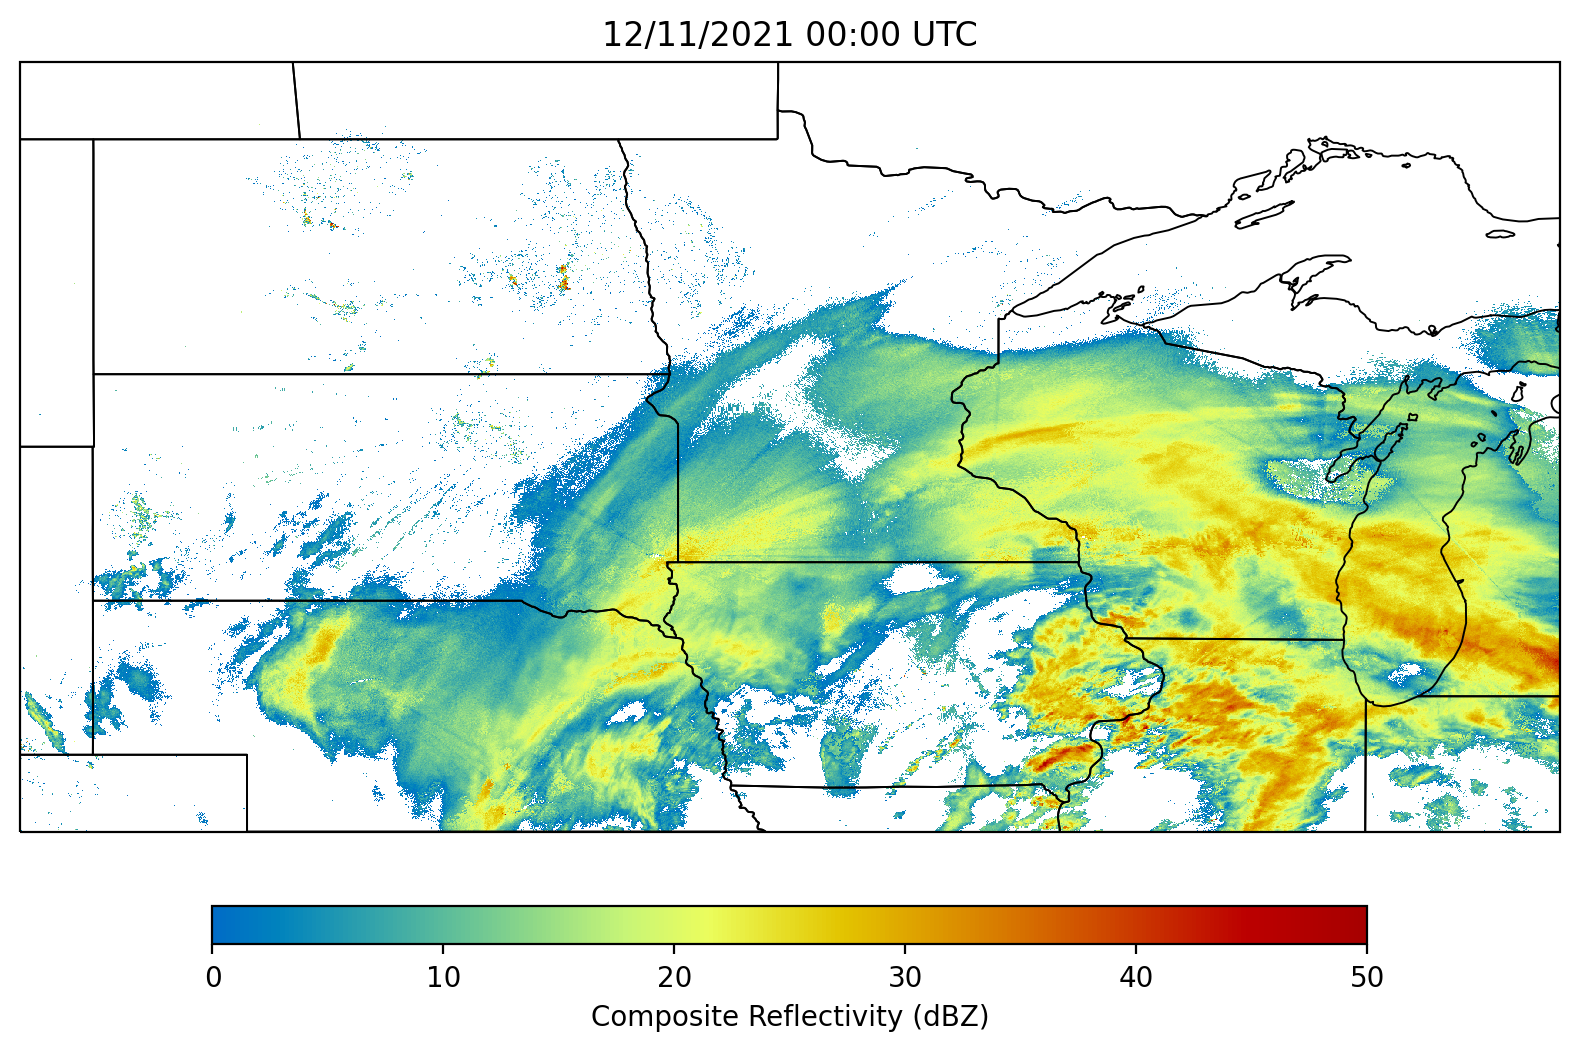

In [10]:
ext = [lon_min, lon_max, lat_min, lat_max]
fig = plt.figure(figsize=(8, 8), dpi=200)
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.set_extent(ext)

# Create a feature for States/Admin 1 regions at 1:10m from Natural Earth
ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)

mosaic.get_comp()
valmask = np.ma.masked_where(mosaic.mrefl3d_comp <= 0, mosaic.mrefl3d_comp)
cs = plt.pcolormesh(mosaic.Longitude, mosaic.Latitude, valmask, vmin=0, vmax=50,
                    cmap='pyart_HomeyerRainbow', transform=projection)
plt.colorbar(cs, label='Composite Reflectivity (dBZ)',
             orientation='horizontal', pad=0.05, shrink=0.75, fraction=0.05, aspect=30)
plt.title(dt.strftime('%m/%d/%Y %H:%M UTC'))
outfile_date = dt.strftime('%Y%m%d_%H%M')
fig.tight_layout()
fig.savefig(f'{outfile_date}_mosaic.png',bbox_inches='tight')